In [1]:
import numpy as np
import tensorflow as tf
import pennylane as qml
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from src.learn import *
from src.quantum_dense_net import QuantumDenseNet

# Prepare data

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

class_n = max(y) + 1
one_hot = np.zeros((y.shape[0], class_n))
one_hot[np.arange(y.size), y] = 1
y = one_hot
# Because there is no alternative of sigmoid in quantum nets
# we will make targets to be a range from -1 to 1 for symmetry
y = y * 2 - 1

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
mean = np.mean(X_train, axis = 0)
X_train -= mean
X_test -= mean
# Due to the limited size of infinite dimensional hilbert space in simulation we will put all data in a range from -1 to 1
anti_var = np.max(abs(X_train), axis = 0)
X_train /=  anti_var
X_test /=  anti_var

# Set common params

In [5]:
tf.random.set_seed(42)

In [6]:
bs = 4
epochs = 40

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(bs)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(bs)

In [7]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)

In [8]:
def acc_fn(out, y):
    pred = tf.math.argmax(out, axis = 1)
    one_hot = np.zeros((pred.shape[0], class_n))
    one_hot[np.arange(pred.shape[0]), pred] = 1
    vector = one_hot * 2 - 1
    f = tf.cast(vector == y, tf.float32)
    return float(tf.reduce_mean(f))

# Train classical model for comparison 

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.nn.relu, input_shape=(4,)),
    tf.keras.layers.Dense(3, activation=tf.nn.tanh),
])

In [10]:
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs)


Start of epoch 0
Train and test losses: 0.6418, 0.6103
Metric: 0.8333

Start of epoch 1
Train and test losses: 0.4677, 0.4298
Metric: 0.8500

Start of epoch 2
Train and test losses: 0.3701, 0.3248
Metric: 0.9000

Start of epoch 3
Train and test losses: 0.3049, 0.2584
Metric: 0.9167

Start of epoch 4
Train and test losses: 0.2563, 0.2113
Metric: 0.9500

Start of epoch 5
Train and test losses: 0.2183, 0.1737
Metric: 0.9833

Start of epoch 6
Train and test losses: 0.1885, 0.1439
Metric: 0.9833

Start of epoch 7
Train and test losses: 0.1652, 0.1208
Metric: 1.0000

Start of epoch 8
Train and test losses: 0.1468, 0.1032
Metric: 1.0000

Start of epoch 9
Train and test losses: 0.1321, 0.0888
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1203, 0.0774
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1107, 0.0690
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.1029, 0.0624
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.0965, 0.0572
Metric: 1.0000

S

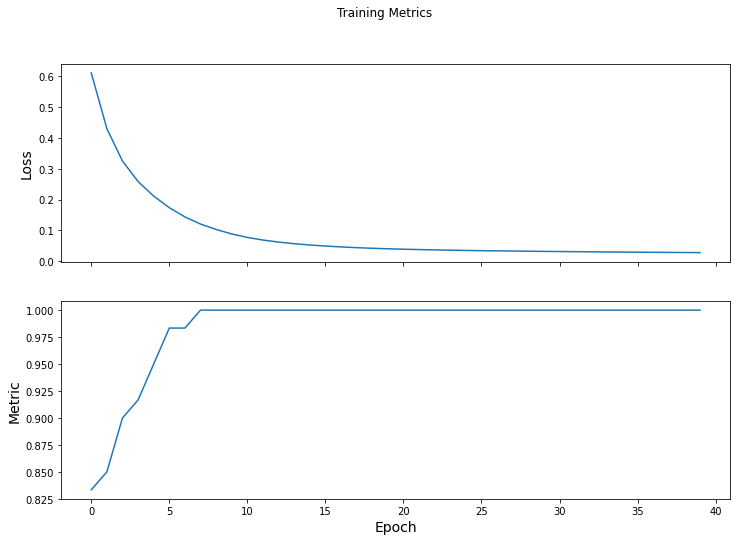

In [11]:
plot(te_r, acc)

# Train quantum model

In [12]:
qml.enable_tape()
cutoff_dim = 9
dev = qml.device('strawberryfields.tf', cutoff_dim = cutoff_dim, wires = 4)
qml.enable_tape()

In [13]:
# it seems that it is not possible to calc qml.state() for fock space right now ...
qml.enable_tape() 

Use Kerr activation on the last layer. This does not guarantee that output will be in some range, but for predication we use argmax so it is not crucial

In [14]:
model = QuantumDenseNet(4, class_n, layers = 2, dev = dev)
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0
Train and test losses: 0.3930, 0.3968
Metric: 0.9000

Start of epoch 1
Train and test losses: 0.3465, 0.3503
Metric: 0.9000

Start of epoch 2
Train and test losses: 0.3443, 0.3438
Metric: 0.9000

Start of epoch 3
Train and test losses: 0.3108, 0.2989
Metric: 0.9333

Start of epoch 4
Train and test losses: 0.2866, 0.2766
Metric: 0.9500

Start of epoch 5
Train and test losses: 0.2732, 0.2615
Metric: 0.9500

Start of epoch 6
Train and test losses: 0.2449, 0.2199
Metric: 0.9833

Start of epoch 7
Train and test losses: 0.2314, 0.1983
Metric: 0.9833

Start of epoch 8
Train and test losses: 0.2032, 0.1568
Metric: 0.9833

Start of epoch 9
Train and test losses: 0.1732, 0.1169
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1560, 0.1037
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1456, 0.0938
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.1408, 0.0889
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.1374, 0.0863
Metric: 1.0000

S

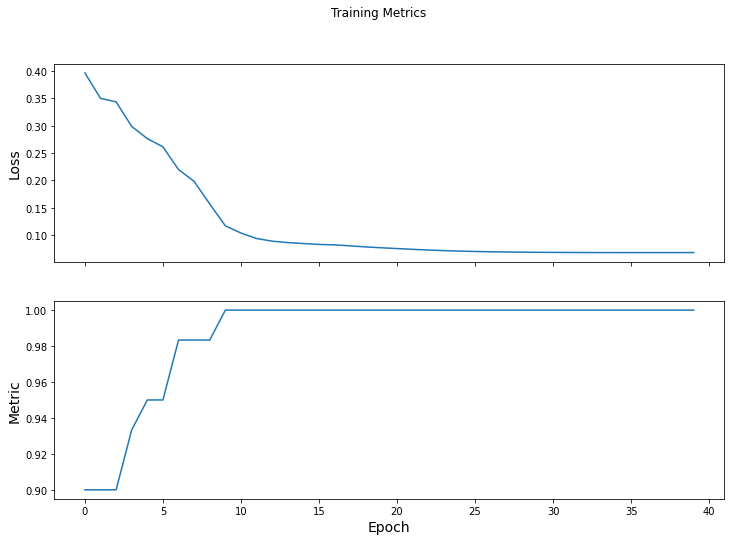

In [15]:
plot(te_r, acc)

Remove the Kerr layer before expval and add activation tanh after.
This will make all outputs to be in range from -1 to 1 as they should be

In [16]:
model = tf.keras.Sequential([
    QuantumDenseNet(4, class_n, layers = 2, last_activation = False, dev = dev),
    tf.keras.layers.Activation('tanh')
])
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0
Train and test losses: 0.3470, 0.3544
Metric: 0.9333

Start of epoch 1
Train and test losses: 0.1837, 0.1642
Metric: 1.0000

Start of epoch 2
Train and test losses: 0.1543, 0.1265
Metric: 1.0000

Start of epoch 3
Train and test losses: 0.1427, 0.1114
Metric: 1.0000

Start of epoch 4
Train and test losses: 0.1370, 0.1024
Metric: 1.0000

Start of epoch 5
Train and test losses: 0.1287, 0.0896
Metric: 1.0000

Start of epoch 6
Train and test losses: 0.1219, 0.0818
Metric: 1.0000

Start of epoch 7
Train and test losses: 0.1162, 0.0739
Metric: 1.0000

Start of epoch 8
Train and test losses: 0.1121, 0.0717
Metric: 1.0000

Start of epoch 9
Train and test losses: 0.1105, 0.0702
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1100, 0.0690
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1092, 0.0677
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.1088, 0.0665
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.1082, 0.0653
Metric: 1.0000

S

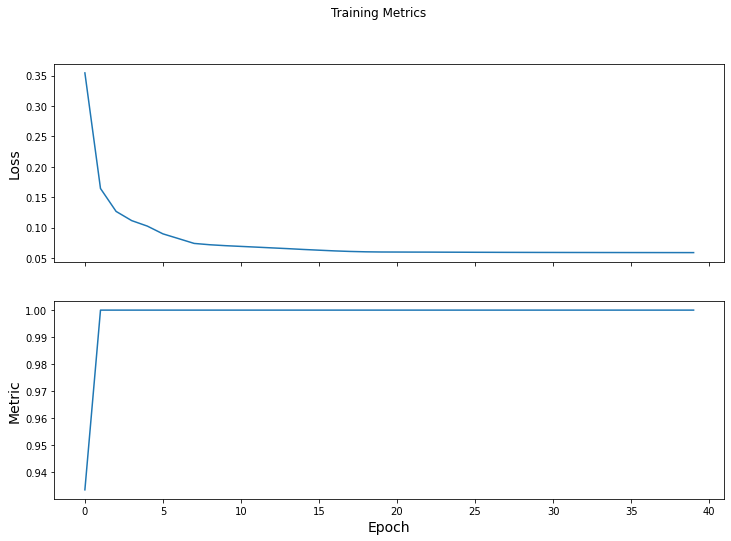

In [17]:
plot(te_r, acc)

Kerr activation followed by tanh for output range consistency

In [18]:
model = tf.keras.Sequential([
    QuantumDenseNet(4, class_n, layers = 2, dev = dev),
    tf.keras.layers.Activation('tanh')
])
tr_r, te_r, acc = learn(model, train_dataset, test_dataset, loss_fn, opt, metric_fn = acc_fn, epochs = epochs, record_trace = False)


Start of epoch 0
Train and test losses: 0.4817, 0.5327
Metric: 0.8167

Start of epoch 1
Train and test losses: 0.3355, 0.3257
Metric: 0.9167

Start of epoch 2
Train and test losses: 0.2842, 0.2682
Metric: 0.9333

Start of epoch 3
Train and test losses: 0.2551, 0.2453
Metric: 0.9500

Start of epoch 4
Train and test losses: 0.1687, 0.1439
Metric: 0.9833

Start of epoch 5
Train and test losses: 0.1426, 0.1095
Metric: 1.0000

Start of epoch 6
Train and test losses: 0.1335, 0.0975
Metric: 1.0000

Start of epoch 7
Train and test losses: 0.1286, 0.0912
Metric: 1.0000

Start of epoch 8
Train and test losses: 0.1238, 0.0857
Metric: 1.0000

Start of epoch 9
Train and test losses: 0.1212, 0.0803
Metric: 1.0000

Start of epoch 10
Train and test losses: 0.1213, 0.0776
Metric: 1.0000

Start of epoch 11
Train and test losses: 0.1215, 0.0766
Metric: 1.0000

Start of epoch 12
Train and test losses: 0.1198, 0.0753
Metric: 1.0000

Start of epoch 13
Train and test losses: 0.1182, 0.0741
Metric: 1.0000

S

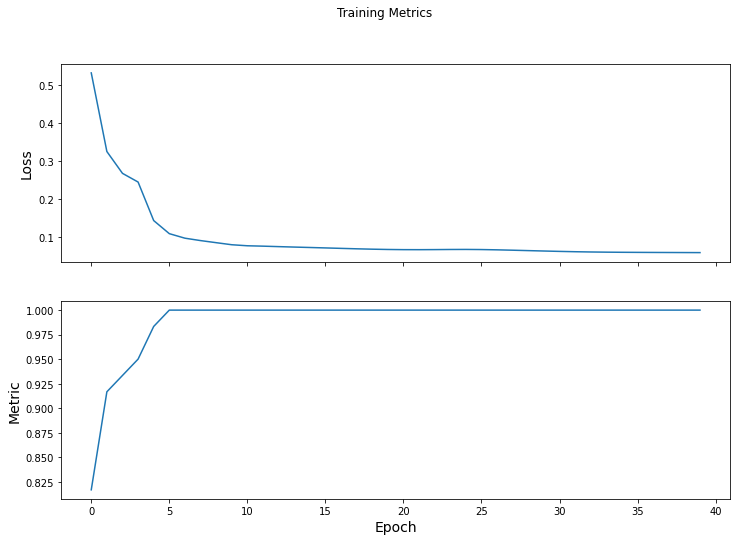

In [19]:
plot(te_r, acc)